## Loading and Preprocessing the Pictures

In [137]:
import numpy as np
import pandas as pd
import os

from PIL import Image

In [138]:
def load_images(images_paths, labels_paths, valid_labels):
    images = []
    labels = []

    no_label_counter = 0
    unidentified_counter = 0

    for images_path, labels_path in zip(images_paths, labels_paths):

        # Load labels from csv file
        labels_df = pd.read_csv(labels_path, sep=';')
        labels_df['Filename'] = [file[:-3] + 'png' for file in labels_df['Filename']]

        for filename in os.listdir(images_path):
            # Load the image using PIL
            img_path = os.path.join(images_path, filename)
            img = Image.open(img_path)

            # Crop the image to the size of the spectrogram
            left, upper, right, lower = 55, 36, 389, 252
            img = img.crop((left, upper, right, lower))

            # Convert image to numpy array and normalize
            img_array = np.array(img)[:, :, :3] / 255.0

            # Extract class label from the CSV file based on the image filename
            label_row = labels_df.loc[labels_df['Filename'] == filename]
            
            if label_row.empty:
                no_label_counter += 1
                continue

            label = label_row['Species'].values[0]

            if label not in valid_labels:
                unidentified_counter += 1
                continue
                
            labels.append(label)
            images.append(img_array)
                

    if no_label_counter:
        print(f'Label not found for {no_label_counter} images : Images will not be used.')
    if unidentified_counter:
        print(f'Bat unidentified for {unidentified_counter} images : Images will not be used.')

    return np.array(images), np.array(labels)

In [139]:
images_folders = ['./Data/dataset1', './Data/dataset2', './Data/dataset3']
labels_paths = ['./Data/dataset1_classified.csv', './Data/dataset2_classified.csv', './Data/dataset3_classified.csv']

valid_labels = ['Bartfledermaus', 'Bechsteinfledermaus', 'Fransenfledermaus',
                'Große Hufeisennase', 'Hufeisennase', 'Mausohr',
                'Langohrfledermaus', 'Wasserfledermaus', 'Wimperfledermaus']

images, labels = load_images(images_folders, labels_paths, valid_labels)
print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

Images shape:  (582, 216, 334, 3)
Labels shape:  (582,)


## Data Exploration

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

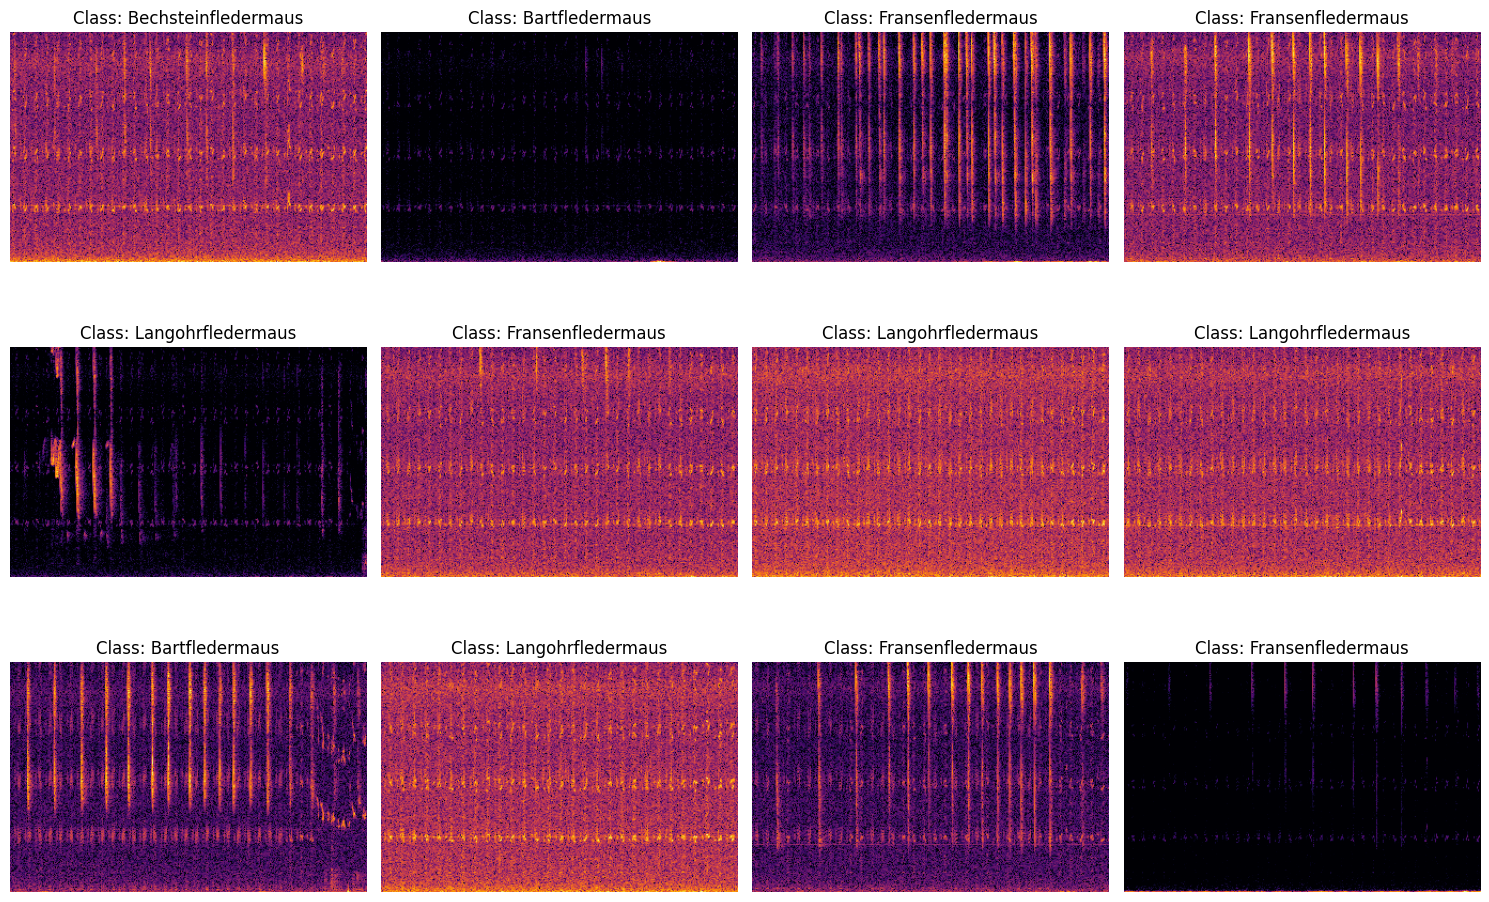

In [141]:
num_samples = 12
indices_to_visualize = random.sample(range(len(images)), num_samples)

num_cols = 4
num_rows = (num_samples + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, index in enumerate(indices_to_visualize):
    row = i // num_cols
    col = i % num_cols

    axes[row, col].imshow(images[index])
    axes[row, col].set_title(f'Class: {labels[index]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

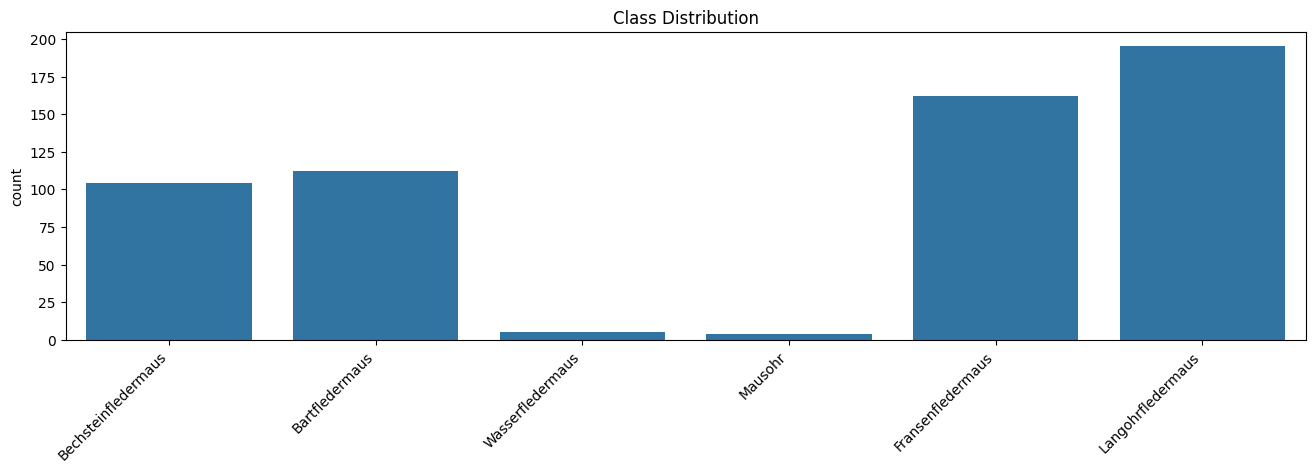

Langohrfledermaus      195
Fransenfledermaus      162
Bartfledermaus         112
Bechsteinfledermaus    104
Wasserfledermaus         5
Mausohr                  4
Name: count, dtype: int64


In [142]:
plt.figure(figsize=(16, 4))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

label_counts = pd.Series(labels).value_counts()
print(label_counts)

In [143]:
print('Mean of images: ', np.mean(images))
print('Std deviation of images: ', np.std(images))

empty_string_indices = labels == ''
print('Missing values in labels: ', np.sum(empty_string_indices))
print('Missing values in images: ', np.isnan(images).sum())

Mean of images:  0.3200254439126128
Std deviation of images:  0.22617266786506793
Missing values in labels:  0
Missing values in images:  0


## Setting up a CNN Model

In [144]:
import tensorflow as tf
from tensorflow import keras

from keras import layers, models

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output

In [145]:
# Converting to numerical labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.3, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(encoded_labels),
                                                  y=encoded_labels)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

In [151]:
# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    width_shift_range = 0.025,
    height_shift_range = 0.015,
    channel_shift_range= 0.2
)

datagen.fit(X_train)

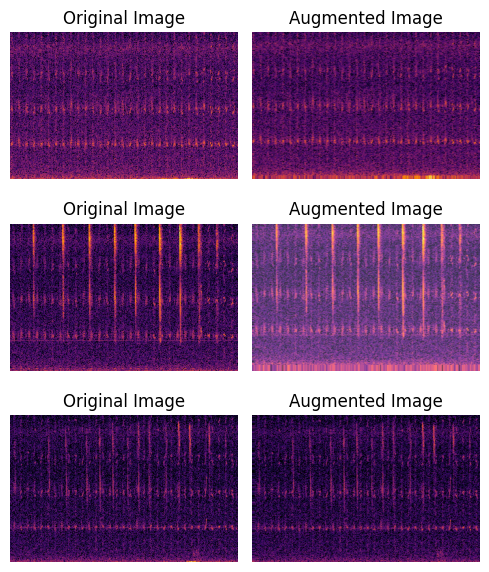

In [160]:
# Generate augmented images
augmented_images = datagen.flow(X_train, batch_size=1, shuffle=False)

# Plot original and augmented images
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(5, 6))

for i in range(num_samples):
    # Original Image
    original_image = X_train[i]
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Augmented Image
    augmented_image = augmented_images.next()[0]
    axes[i, 1].imshow(augmented_image)
    axes[i, 1].set_title('Augmented Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [148]:
# Define a function to build the model with hyperparameters
def build_model(hp):
    model = models.Sequential()

    model.add(layers.Conv2D(hp.Int('conv1_units', min_value=16, max_value=64, step=16), (3, 3), activation='relu', input_shape=(216, 334, 3)))
    model.add(layers.Dropout(hp.Float('dropout_conv1', min_value=0.05, max_value=0.2, step=0.05)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_conv2', min_value=0.05, max_value=0.2, step=0.05)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_conv3', min_value=0.05, max_value=0.2, step=0.05)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_dense', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=20, directory='./cnn-model/tuner_results', project_name='cnn_tuner',
                     overwrite=True)

In [149]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Define low accuracy callback
class LowAccuracy(keras.callbacks.Callback):
    def __init__(self, threshold, patience):
        super(LowAccuracy, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.counter = 0

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy', 0)
        if val_accuracy < self.threshold:
            self.counter += 1
            if self.counter >= self.patience:
                self.model.stop_training = True
                print(f'\nStopping training. Validation accuracy {val_accuracy:.2f} is below the threshold {self.threshold} for a total of {self.patience} epochs.')

low_accuracy = LowAccuracy(threshold=0.02, patience=5)


# Define model checkpoint callback
checkpoint_path = './cnn-model/model_checkpoint.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')


# Define plot callback
class PlotInfo(keras.callbacks.Callback):
    def __init__(self):
        super(PlotInfo, self).__init__()
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []

        self.best_val_loss = float('inf')
        self.best_val_loss_epoch = 1
        self.best_val_accuracy = 0
        self.best_val_accuracy_epoch = 1

        self.epoch = 1
        self.logs = []

    def on_epoch_end(self, epoch, logs=None):
        self.logs.append(logs)
        self.x.append(self.epoch)

        self.losses.append(logs.get('loss', 0))
        self.val_losses.append(logs.get('val_loss', 0))
        self.accuracy.append(logs.get('accuracy', 0))
        self.val_accuracy.append(logs.get('val_accuracy', 0))

        # Check if current val_loss is the best so far
        if logs.get('val_loss') < self.best_val_loss:
            self.best_val_loss = logs.get('val_loss')
            self.best_val_loss_epoch = self.epoch

        # Check if current val_accuracy is the best so far
        if logs.get('val_accuracy') > self.best_val_accuracy:
            self.best_val_accuracy = logs.get('val_accuracy')
            self.best_val_accuracy_epoch = self.epoch

        self.epoch += 1
        clear_output(wait=True)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Subplot for loss
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.scatter(self.best_val_loss_epoch, self.best_val_loss, marker='o', color='red', label=f'best val_loss ({self.best_val_loss:.3f})')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.legend()

        # Subplot for accuracy
        ax2.plot(self.x, self.accuracy, label="accuracy")
        ax2.plot(self.x, self.val_accuracy, label="val_accuracy")
        ax2.scatter(self.best_val_accuracy_epoch, self.best_val_accuracy, marker='o', color='green', label=f'best val_accuracy ({self.best_val_accuracy:.3f})')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('accuracy')
        ax2.legend()

        fig.suptitle(f'CNN tuner - Epoch {self.epoch - 1}', fontsize=16)
        plt.tight_layout()
        plt.show()

plot_info = PlotInfo()

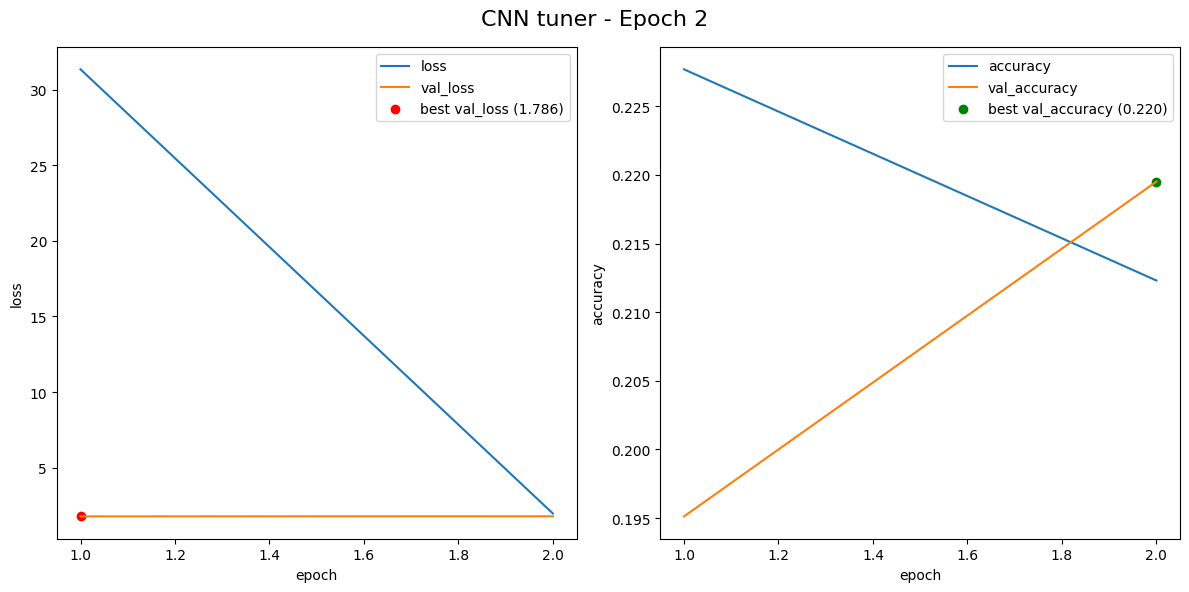

11/11 [==============================] - 37s 3s/step - loss: 1.9754 - accuracy: 0.2123 - val_loss: 1.7914 - val_accuracy: 0.2195
Epoch 3/50
 3/11 [=======>......................] - ETA: 15s - loss: 2.8926 - accuracy: 0.1304

KeyboardInterrupt: 

In [150]:
# Search for the best hyperparameters
tuner.search(datagen.flow(X_train, y_train, batch_size=32),
             epochs=50,
             validation_data=datagen.flow(X_val, y_val, batch_size=32),
             class_weight=class_weights_dict,
             callbacks=[early_stopping, low_accuracy, plot_info, model_checkpoint])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save('./cnn-model/best_model.keras')

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 214, 332, 64)      1792      
                                                                 
 dropout (Dropout)           (None, 214, 332, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 107, 166, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 164, 96)      55392     
                                                                 
 dropout_1 (Dropout)         (None, 105, 164, 96)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 52, 82, 96)        0         
 g2D)                                                   

In [ ]:
# Load the best model
cnn_model = keras.models.load_model('./cnn-model/best_model.keras')

In [ ]:
# Train the best model again
history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        epochs=50,
                        class_weight=class_weights_dict,
                        validation_data=datagen.flow(X_val, y_val, batch_size=32),
                        callbacks=[early_stopping])

Epoch 1/50
11/11 [==============================] - 30s 3s/step - loss: 0.3491 - accuracy: 0.8862 - val_loss: 0.9577 - val_accuracy: 0.7317
Epoch 2/50
11/11 [==============================] - 28s 3s/step - loss: 0.2563 - accuracy: 0.8585 - val_loss: 1.0465 - val_accuracy: 0.7195
Epoch 3/50
11/11 [==============================] - 29s 3s/step - loss: 0.2162 - accuracy: 0.9169 - val_loss: 0.9903 - val_accuracy: 0.7683
Epoch 4/50
11/11 [==============================] - 28s 3s/step - loss: 0.1746 - accuracy: 0.9477 - val_loss: 1.1443 - val_accuracy: 0.7683
Epoch 5/50
11/11 [==============================] - 28s 3s/step - loss: 0.1718 - accuracy: 0.9169 - val_loss: 1.0964 - val_accuracy: 0.7805
Epoch 6/50
11/11 [==============================] - 28s 3s/step - loss: 0.1794 - accuracy: 0.9385 - val_loss: 1.5535 - val_accuracy: 0.7805
Epoch 7/50
11/11 [==============================] - 28s 3s/step - loss: 0.1124 - accuracy: 0.9477 - val_loss: 1.0820 - val_accuracy: 0.7805
Epoch 8/50
11/11 [==

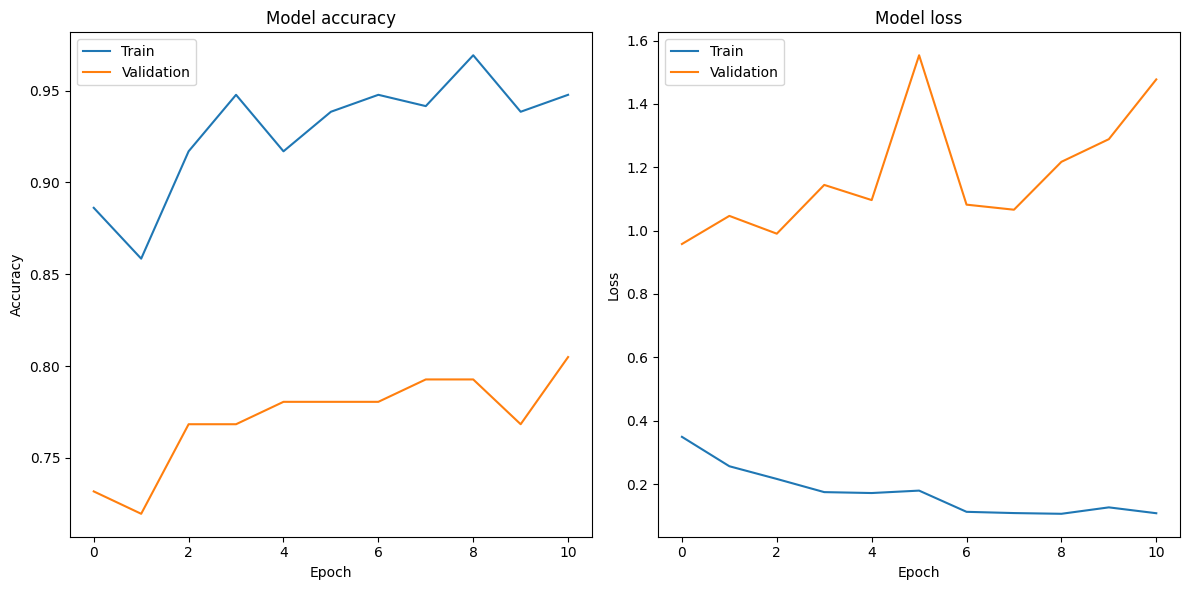

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
cnn_model.save('./cnn-model/final_model.keras')

In [ ]:
# Load the trained model
cnn_final_model = keras.models.load_model('./cnn-model/final_model.keras')

## Analyzing Results

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Evaluate the best model on the test set
test_loss, test_acc = cnn_final_model.evaluate(X_test, y_test)

6/6 [==============================] - 2s 254ms/step - loss: 0.6874 - accuracy: 0.8171


In [ ]:
all_classes = label_encoder.classes_

y_pred_probabilities = cnn_final_model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)
y_test_int = np.argmax(keras.utils.to_categorical(y_test), axis=1)

# Extract unique classes present in the test dataset
unique_classes_in_test = np.unique(y_test_int)

# Filter the all_classes list to include only those present in the test dataset
target_classes = [all_classes[i] for i in unique_classes_in_test]

# Convert the integer labels to string labels using the label_encoder
y_test_int_str = label_encoder.inverse_transform(y_test_int)
y_pred_str = label_encoder.inverse_transform(y_pred)

6/6 [==============================] - 2s 241ms/step


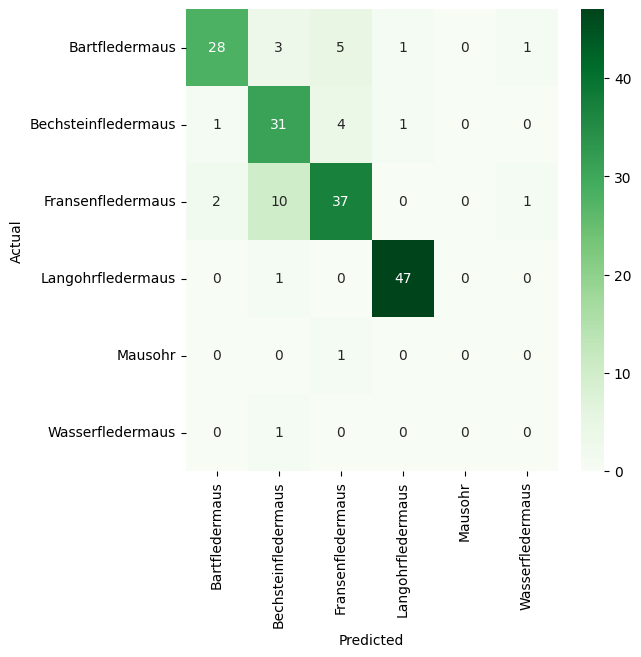

In [ ]:
# Generate confusion matrix
confusion_m = confusion_matrix(y_test_int, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_m, annot=True, fmt='d', cmap='Greens', xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Classification report
print(classification_report(y_test_int_str, y_pred_str, target_names=target_classes, zero_division=1))

                     precision    recall  f1-score   support

     Bartfledermaus       0.90      0.74      0.81        38
Bechsteinfledermaus       0.67      0.84      0.75        37
  Fransenfledermaus       0.79      0.74      0.76        50
  Langohrfledermaus       0.96      0.98      0.97        48
            Mausohr       1.00      0.00      0.00         1
   Wasserfledermaus       0.00      0.00      1.00         1

           accuracy                           0.82       175
          macro avg       0.72      0.55      0.72       175
       weighted avg       0.83      0.82      0.82       175

